# xDB Training

A notebook exploring the xDB dataset tier3 part for Building Segmentation Model and Damaged Classification Model

In [1]:
# In a Jupyter notebook or IPython environment, run this in the first cell
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

## Fine Tune ResNet Unet on xDB Data

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Define the transformation pipeline
def get_train_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        # Random horizontal flip
        A.HorizontalFlip(p=0.8),
        # Random vertical flip
        A.VerticalFlip(p=0.8),
        # Random rotation
        A.RandomRotate90(p=0.05),
        # Random brightness and contrast adjustments
        A.RandomBrightnessContrast(p=0.2),
        # Random contrast adjustment
        A.RandomGamma(p=0.2),
        # Random scale and aspect ratio change
        A.RandomSizedCrop(min_max_height=(image_size[0], image_size[1]), size=(image_size[0], image_size[1]), p=0.8, w2h_ratio=0.5),
        # Random blur
        A.GaussianBlur(p=0.2),
        # Convert to tensor (works for both image and mask)
        ToTensorV2()
    ])
    return transform

def get_val_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        ToTensorV2()
    ])
    return transform

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import xDB_Damaged_Building

origin_dir = "../data/xDB/tier3"

data_train  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_train_augmentation_pipeline(image_size=(512,512)),
    type="train",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_val  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="val",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_test  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="test",
    val_ratio=0.1, 
    test_ratio=0.1,
)

Loaded 5097 train labels.
Loaded 636 val labels.
Loaded 636 test labels.


In [13]:
from models import ResNet_UNET 

model = ResNet_UNET(
        in_channels=3,
        out_channels=2,
        backbone_name="resnet50",
        pretrained=True,
        freeze_backbone=False,
    )

In [14]:
import torch
from torchsummary import summary 
# Before training, wrap the model for Data Parallelism
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

model.to("cuda")

summary(model, input_size=(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [15]:
from torch.utils.data import DataLoader
train_dl = DataLoader(data_train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
val_dl = DataLoader(data_val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

In [16]:
from torch.nn.modules.loss import _Loss
from typing import List

class Ensemble(_Loss):
    def __init__(
        self,
        list_losses: List[_Loss] = [],
        weights: List[float] = []
    ):
        super().__init__()
        self.list_losses = list_losses
        self.weights = weights

        assert len(list_losses) > 0, "List of losses cannot be empty."
        assert len(weights) == len(list_losses), "Weights must match the number of losses."

        # Normalize weights to sum to 1
        total_weight = sum(self.weights)
        assert total_weight > 0, "Weights must sum to a positive value."
        self.weights = [w / total_weight for w in self.weights]

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes the weighted ensemble loss.
        
        :param inputs: Predictions from the model.
        :param targets: Ground truth labels.
        :return: Weighted ensemble loss.
        """
        total_loss = 0.0
        for weight, loss_fn in zip(self.weights, self.list_losses):
            loss = loss_fn(inputs, targets)
            total_loss += weight * loss
        
        return total_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from training import train 
from losses import SoftCrossEntropyLoss
from losses import DiceLoss, FocalLoss
from metrics import f1_score, iou_score, balanced_accuracy

mode = "multiclass"
reduction = "weighted"
class_weights = [0.1, 0.9]

optimizer = optim.AdamW(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.00015, weight_decay=1e-6)
params_opt = {}
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 11, 17, 25, 33, 47, 50, 60, 70, 90, 110, 130, 150, 170, 180, 190], gamma=0.5)

params_sc = {}
criterion = Ensemble(list_losses=[DiceLoss(mode=mode), FocalLoss(mode=mode)], weights= [1.0, 10.0]).cuda()
# Define Metrics 
metrics = [balanced_accuracy, f1_score, iou_score]

# Early Stopping 
early_stopping_params = {"patience":5, "trigger_times": 0}

torch.cuda.empty_cache()
train(
    model,
    train_dl=train_dl,
    valid_dl=val_dl,
    optimizer=optimizer,
    scheduler=scheduler,
    params_opt=params_opt,
    params_sc=params_sc,
    metrics=metrics,
    nb_epochs=55,
    loss_fn=criterion,
    experiment_name="xDB_ResNet50_Unet",
    log_dir="../runs",
    model_dir="../models",
    early_stopping_params = early_stopping_params,
    image_key="image",
    training_log_interval=5,
    verbose=False,
    is_mixed_precision=True, 
    reduction=reduction,
    class_weights=class_weights
)


In [18]:
test_dl = DataLoader(data_test, batch_size=5, shuffle=True)

In [19]:
input_test = next(iter(test_dl))
outputs = model.predict(input_test["image"].to("cuda"))

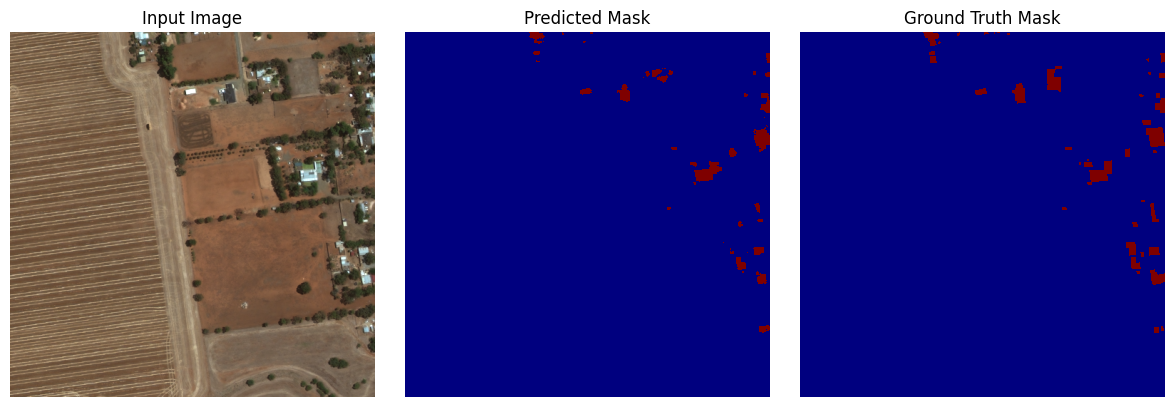

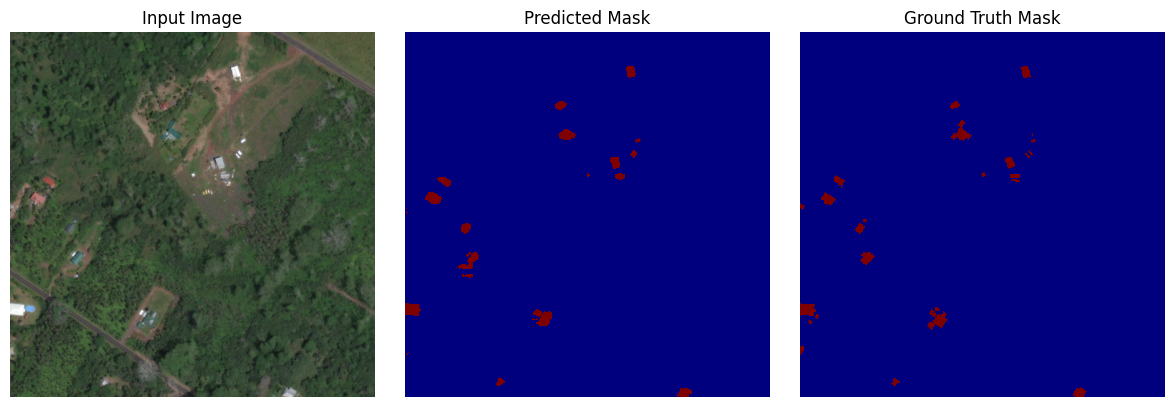

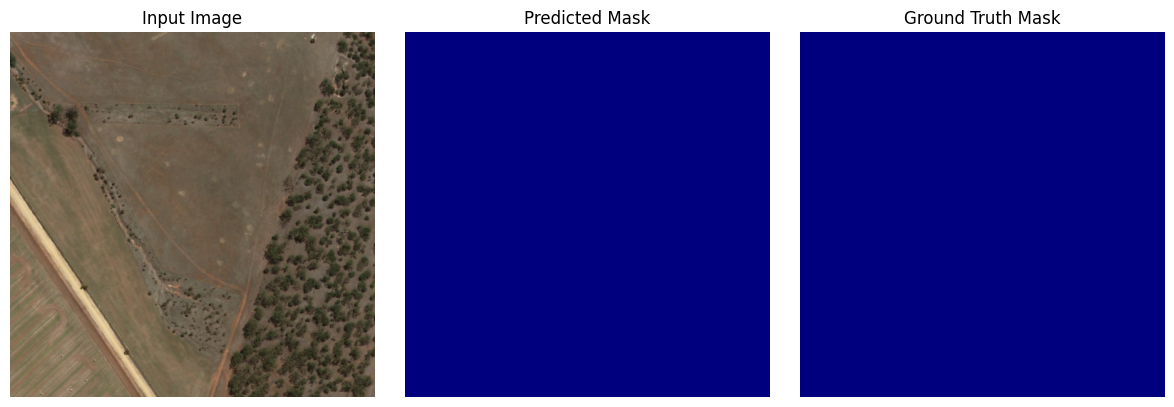

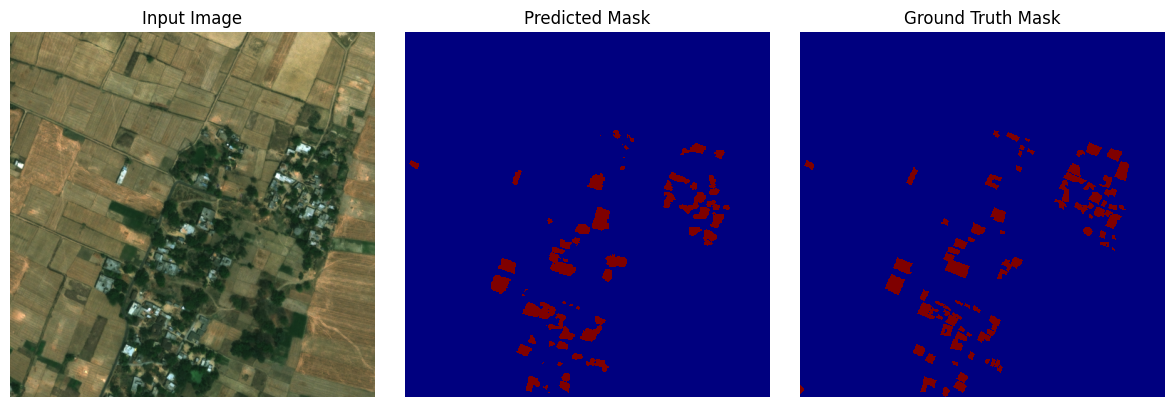

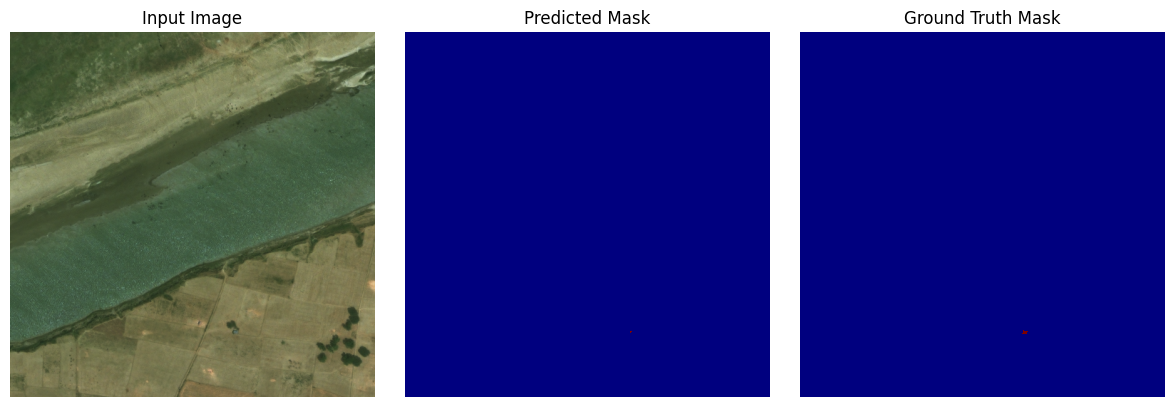

In [20]:
from utils import display_predictions_batch

display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs,
    mask_labels=input_test["mask"]
    )

In [30]:
input_test["image"].shape

torch.Size([5, 3, 512, 512])

In [31]:
from training import augmentation_test_time
import numpy as np
# Define Albumentations augmentations
augmentations = [
    A.HorizontalFlip(p=1.0),  # Horizontal flip
    A.VerticalFlip(p=1.0)    # Vertical flip
]
outputs_tta = augmentation_test_time(model, batch=input_test, list_augmentations=augmentations, aggregation="mean", image_tag="image", device="cuda" )
outputs_tta = np.argmax(outputs_tta, axis=1) 

torch.Size([5, 3, 512, 512])
torch.Size([5, 3, 512, 512])


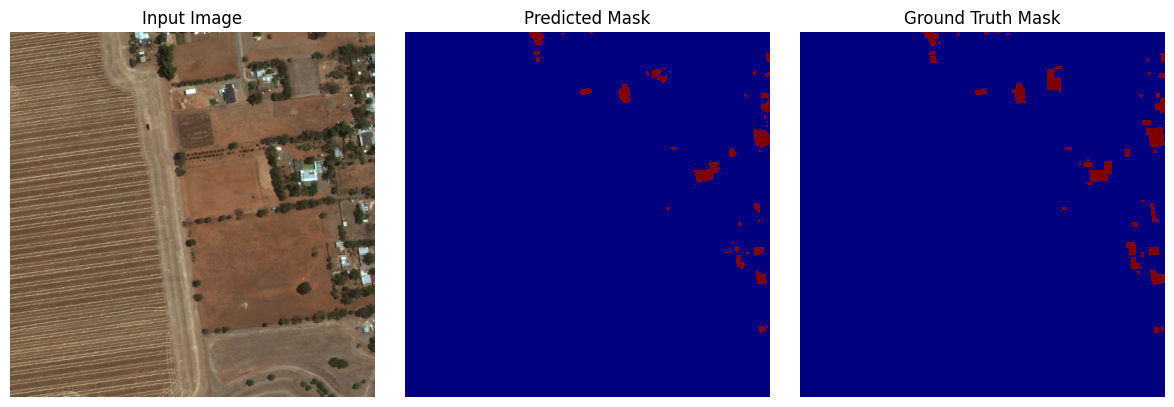

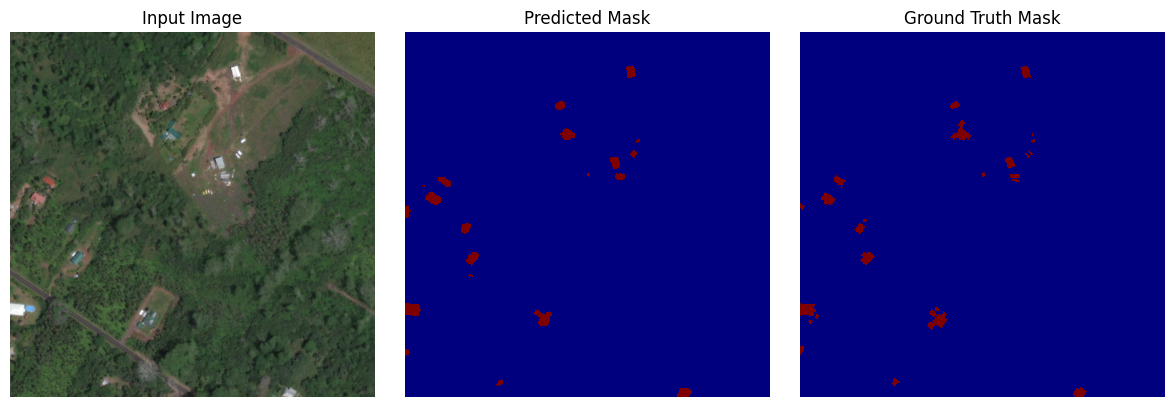

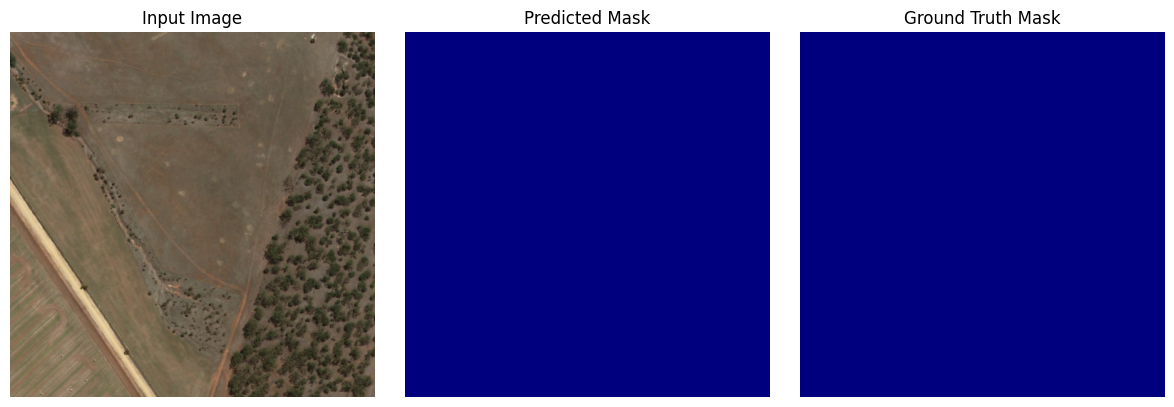

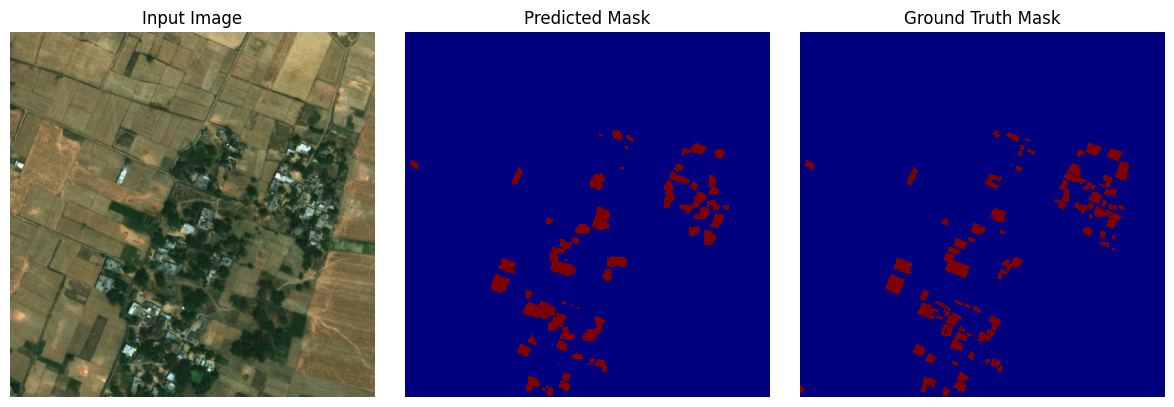

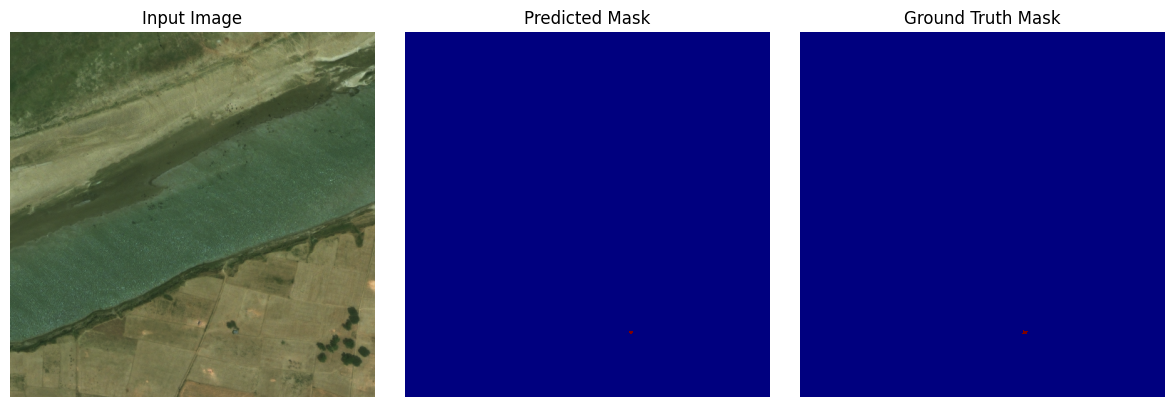

In [32]:
display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs_tta,
    mask_labels=input_test["mask"]
    )

In [42]:
### Testing TTA efficiency 
from training import testing 

epoch_tloss, test_metrics = testing(
    model=model,
    test_dataloader=test_dl,
    loss_fn=criterion,
    metrics=metrics,
    image_key="image",
    verbose=True, 
    is_mixed_precision= False,
    num_classes= 2,
    reduction= "weighted",
    class_weights=[0.1, 0.9], 
    tta=False
)

Testing: 100%|██████████| 128/128 [03:27<00:00,  1.62s/batch, Loss=0.256]


In [43]:
print("Test Loss without TTA : ", epoch_tloss)
print("Metrics without TTA : ",test_metrics)

Test Loss without TTA :  0.2420090448884469
Metrics without TTA :  {'balanced_accuracy': tensor(0.8611), 'f1_score': tensor(0.7848), 'iou_score': tensor(0.6690)}


In [45]:
### Testing TTA efficiency 
from training import testing 

epoch_tloss, test_metrics = testing(
    model=model,
    test_dataloader=test_dl,
    loss_fn=criterion,
    metrics=metrics,
    image_key="image",
    verbose=True, 
    is_mixed_precision= False,
    num_classes= 2,
    reduction= "weighted",
    class_weights=[0.1, 0.9], 
    tta=True
)

Testing: 100%|██████████| 128/128 [07:37<00:00,  3.57s/batch, Loss=0.199]


In [46]:
print("Test Loss with TTA : ", epoch_tloss)
print("Metrics with TTA : ", test_metrics)

Test Loss with TTA :  0.19553206251852168
Metrics with TTA :  {'balanced_accuracy': tensor(0.8620), 'f1_score': tensor(0.7812), 'iou_score': tensor(0.6670)}


## Fine Tune Mask R CNN on xDB dataset - Building Footprint Segmentation 

In [6]:
def calculate_detection_metrics(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels, iou_threshold=0.5):
    """
    Calculate precision, recall, and F1 score for instance-level detection.

    Parameters:
        pred_boxes (Tensor): Predicted bounding boxes (N, 4).
        pred_scores (Tensor): Confidence scores for each predicted box (N).
        pred_labels (Tensor): Predicted labels (N).
        true_boxes (Tensor): Ground truth bounding boxes (M, 4).
        true_labels (Tensor): Ground truth labels (M).
        iou_threshold (float): IoU threshold to determine true positives.

    Returns:
        dict: Precision, recall, F1 score, and additional metrics (e.g., TP, FP, FN).
    """
    if len(pred_boxes) == 0 and len(true_boxes) == 0:
        # No predictions and no ground truths: perfect precision and recall
        return {
            "precision": 1.0,
            "recall": 1.0,
            "f1_score": 1.0,
            "true_positive": 0,
            "false_positive": 0,
            "false_negative": 0,
        }
    elif len(pred_boxes) == 0:
        # No predictions: all ground truths are false negatives
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1_score": 0.0,
            "true_positive": 0,
            "false_positive": 0,
            "false_negative": len(true_boxes),
        }
    elif len(true_boxes) == 0:
        # No ground truths: all predictions are false positives
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1_score": 0.0,
            "true_positive": 0,
            "false_positive": len(pred_boxes),
            "false_negative": 0,
        }
    # Compute IoU between all predicted and ground truth boxes
    ious = torchvision.ops.box_iou(pred_boxes, true_boxes)

    # Initialize matches
    matched_preds = set()
    matched_truths = set()

    # Greedy matching: Iterate over IoUs and match predictions to ground truths
    for pred_idx, iou_row in enumerate(ious):
        if iou_row.numel() > 0:  # Ensure there are ground truth boxes to compare
            max_iou, truth_idx = iou_row.max(0)  # Best IoU for this prediction
            if max_iou > iou_threshold and truth_idx.item() not in matched_truths:
                matched_preds.add(pred_idx)
                matched_truths.add(truth_idx.item())

    # Compute TP, FP, FN
    true_positive = len(matched_preds)
    false_positive = len(pred_boxes) - true_positive
    false_negative = len(true_boxes) - true_positive

    # Calculate precision, recall, F1-score
    precision = true_positive / (true_positive + false_positive + 1e-6)
    recall = true_positive / (true_positive + false_negative + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "true_positive": true_positive,
        "false_positive": false_positive,
        "false_negative": false_negative,
    }
def calculate_segmentation_metrics(pred_masks, true_masks, iou_threshold=0.5):
    """
    Calculate IoU and Dice coefficient for segmentation masks.

    Parameters:
        pred_masks (Tensor): Predicted binary masks (N, H, W).
        true_masks (Tensor): Ground truth binary masks (M, H, W).
        iou_threshold (float): Threshold for determining matches.

    Returns:
        dict: IoU and Dice coefficient.
    """
    # Convert masks to boolean
    pred_masks = pred_masks.bool()
    true_masks = true_masks.bool()

    # Compute pairwise IoU matrix
    pred_masks_flat = pred_masks.view(pred_masks.size(0), -1)
    true_masks_flat = true_masks.view(true_masks.size(0), -1)

    intersection = (pred_masks_flat.unsqueeze(1) & true_masks_flat.unsqueeze(0)).sum(-1).float()
    union = (pred_masks_flat.unsqueeze(1) | true_masks_flat.unsqueeze(0)).sum(-1).float()
    iou_matrix = intersection / (union + 1e-6)

    # Match predicted masks to true masks based on IoU
    matched_preds = set()
    matched_truths = set()
    for pred_idx in range(iou_matrix.size(0)):
        iou_row = iou_matrix[pred_idx]
        max_iou, truth_idx = iou_row.max(0)
        if max_iou > iou_threshold and truth_idx.item() not in matched_truths:
            matched_preds.add(pred_idx)
            matched_truths.add(truth_idx.item())

    # Calculate overall intersection and union for matched pairs
    total_intersection = 0
    total_union = 0
    for pred_idx, truth_idx in zip(matched_preds, matched_truths):
        total_intersection += (pred_masks[pred_idx] & true_masks[truth_idx]).sum().item()
        total_union += (pred_masks[pred_idx] | true_masks[truth_idx]).sum().item()

    # Compute Dice coefficient and IoU
    dice_coeff = (2 * total_intersection / (total_intersection + total_union + 1e-6))
    iou = total_intersection / (total_union + 1e-6)

    return {"iou": iou, "dice": dice_coeff}

In [7]:
import math
import sys
import time
from collections import defaultdict

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from torchvision.ops.boxes import box_iou


# Utility to reduce loss dictionary across GPUs (for distributed training)
from training.utils import reduce_dict
from datasets.utils import custom_collate_fn


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10, scaler=None, writer=None):
    """
    Train the model for one epoch.

    Parameters:
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        data_loader (DataLoader): DataLoader for the training dataset.
        device (torch.device): Device to run the training on.
        epoch (int): Current epoch number.
        print_freq (int): Frequency of printing training stats.
        scaler (torch.cuda.amp.GradScaler): GradScaler for mixed precision training (optional).
        writer (SummaryWriter): TensorBoard writer for logging (optional).

    Returns:
        float: The average loss over the epoch.
    """
    model.train()
    lr_scheduler = None
    if epoch == 0:
        # Warm-up learning rate for the first epoch
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    print(f"Starting epoch {epoch}...")
    running_loss = 0.0

    for i, (images, targets) in enumerate(data_loader):
        # Prepare data for training
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # Forward pass with optional mixed precision
        with torch.amp.autocast(device_type=device, enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce loss for logging
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        # Update running loss
        running_loss += loss_value

        # Check for NaN or infinite loss
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(f"Reduced Loss Dictionary: {loss_dict_reduced}")
            sys.exit(1)

        # Backpropagation and optimization
        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        # Step learning rate scheduler if present
        if lr_scheduler is not None:
            lr_scheduler.step()

        # Logging
        if i % print_freq == 0 or i == len(data_loader) - 1:
            global_step_number = len(data_loader) * epoch + i
            avg_loss = running_loss / (i + 1)
            print(
                f"Epoch [{epoch}], Batch [{i}/{len(data_loader)}]: "
                f"Loss: {loss_value:.4f}, Avg Loss: {avg_loss:.4f}, "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}"
            )
            if writer:
                writer.add_scalar("Training/Loss", avg_loss, global_step_number)
                writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], global_step_number)

    avg_epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch} finished. Average Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


@torch.inference_mode()
def evaluate(model, data_loader, device, epoch, writer=None):
    """
    Evaluate a Mask R-CNN model on a custom dataset.

    Parameters:
        model (torch.nn.Module): The Mask R-CNN model to evaluate.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to run the evaluation on.

    Returns:
        dict: A dictionary containing instance-level and segmentation-level metrics.
    """
    # Store current thread settings and switch to single-thread
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)

    cpu_device = torch.device("cpu")
    model.eval()

    # Initialize metrics storage
    instance_metrics = defaultdict(list)
    segmentation_metrics = defaultdict(list)

    # Evaluation loop
    with tqdm(total=len(data_loader), desc="Evaluating", unit="batch") as pbar:
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [
                {k: v.to(cpu_device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} 
                for t in targets
            ]

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            # Get model predictions
            model_time = time.time()
            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            model_time = time.time() - model_time

            # Metric calculations
            for output, target in zip(outputs, targets):
                # Handle case with no predicted boxes
                if len(output["boxes"]) == 0:
                    instance_metrics["precision"].append(0.0)
                    instance_metrics["recall"].append(0.0)
                    instance_metrics["f1_score"].append(0.0)
                else:
                    # Detection metrics
                    metrics = calculate_detection_metrics(
                        output["boxes"], output["scores"], output["labels"],
                        target["boxes"], target["labels"]
                    )
                    instance_metrics["precision"].append(metrics["precision"])
                    instance_metrics["recall"].append(metrics["recall"])
                    instance_metrics["f1_score"].append(metrics["f1_score"])

                # Handle case with no predicted masks
                if "masks" in output and len(output["masks"]) > 0:
                    pred_masks = (output["masks"] > 0.5).squeeze(1)  # Binarize predicted masks
                    true_masks = target["masks"]

                    if pred_masks.size(0) > 0 and true_masks.size(0) > 0:
                        metrics = calculate_segmentation_metrics(pred_masks, true_masks)
                        segmentation_metrics["iou"].append(metrics["iou"])
                        segmentation_metrics["dice"].append(metrics["dice"])
                    else:
                        segmentation_metrics["iou"].append(0.0)
                        segmentation_metrics["dice"].append(0.0)

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix(
                model_time=f"{model_time:.4f}s",
                avg_precision=f"{torch.tensor(instance_metrics['precision']).mean().item():.4f}",
                avg_iou=f"{torch.tensor(segmentation_metrics['iou']).mean().item():.4f}"
            )
            

    # Aggregate metrics
    aggregated_metrics = {
        "instance": {k: torch.tensor(v).mean().item() for k, v in instance_metrics.items()},
        "segmentation": {k: torch.tensor(v).mean().item() for k, v in segmentation_metrics.items()},
    }

    if writer is not None:
        for k, v in instance_metrics.items(): 
            writer.add_scalar(f"Validation/{k}", torch.tensor(v).mean().item(), epoch)
        for k, v in segmentation_metrics.items():
            writer.add_scalar(f'Validation/{k}', torch.tensor(v).mean().item(), epoch)

    print("Evaluation complete.")
    torch.set_num_threads(n_threads)  # Restore original thread settings
    return aggregated_metrics

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torchvision.transforms import v2
import torch

def get_augmentation_training_pipeline(target_size: tuple):
    """
    Creates a data augmentation pipeline that includes resizing.

    Parameters:
    - target_size (tuple): Desired output size (height, width).

    Returns:
    - torchvision.transforms.Compose: Augmentation pipeline.
    """
    return  v2.Compose([
        v2.RandomResizedCrop(size=target_size, antialias=True),
        v2.RandomHorizontalFlip(p=0.5),    # Randomly flip the image horizontally
        v2.RandomVerticalFlip(p=0.5), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       
    ])

def get_augmentation_validation_pipeline(target_size: tuple):
    return v2.Compose([
        v2.Resize(size=target_size),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
# Test 
from datasets import xDB_Instance_Building

origin_dir = "../data/xDB/tier3"

data_test  = xDB_Instance_Building(
    origin_dir =  origin_dir,
    mode="building",
    time="pre",
    transform=get_augmentation_validation_pipeline(target_size=(512,512)),
    type="test",
    val_ratio=0.1, 
    test_ratio=0.1,
    task="semantic"
)

Loaded 636 test labels.


### Training MaskRCNN

In [ ]:
import torch
from models import Maskrcnn
from datasets.utils import custom_collate_fn  # Assuming your custom collate function is defined here

# Check if a GPU is available, else use the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")

scaler = torch.amp.GradScaler()

# Initialize the Mask R-CNN model
model = Maskrcnn(num_classes=2, hidden_layer_dim=256, pretrained=True)
model.to(device)

# Define training and validation DataLoaders
train_dl = torch.utils.data.DataLoader(
    data_train,  # Replace with your training dataset
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn,
    pin_memory=True
)

valid_dl = torch.utils.data.DataLoader(
    data_val,  # Replace with your validation dataset
    batch_size=16,
    shuffle=False,  # No need to shuffle validation data
    collate_fn=custom_collate_fn,
    pin_memory=True
)

# Prepare the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Define a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,  # Decrease LR every 3 epochs
    gamma=0.1     # Multiply LR by 0.1 at each step
)

# Training parameters
num_epochs = 10  # Set to 2 for now; can increase for better results

print("Setup complete! Ready to start training.")


In [14]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os 

experiment_name = "xDB_ResNet50_MaskRCNN"
log_dir = "../runs"
# Create a directory for the experiment
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(log_dir, f"{experiment_name}_{timestamp}")
print(f"Experiment logs are recorded at {log_dir}")

# Ensure model directory exists
os.makedirs(log_dir, exist_ok=True)


Experiment logs are recorded at ../runs/xDB_ResNet50_MaskRCNN_20241125-224548


In [ ]:
with SummaryWriter(log_dir) as writer:
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=5, scaler=scaler, writer=writer)
        print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {train_loss:.4f}")
        eval_metrics = evaluate(model, valid_dl, device, epoch, writer)
        print(f"Validation Metrics: {eval_metrics}")
        # Step the learning rate scheduler
        lr_scheduler.step()
        model.save(filepath=f"../models/{experiment_name}_checkpoint.pth")

Epoch [3], Batch [180/319]: Loss: 0.4673, Avg Loss: 0.6172, LR: 0.000500
Epoch [3], Batch [185/319]: Loss: 0.6356, Avg Loss: 0.6167, LR: 0.000500
Epoch [3], Batch [190/319]: Loss: 0.5043, Avg Loss: 0.6158, LR: 0.000500
Epoch [3], Batch [195/319]: Loss: 0.5815, Avg Loss: 0.6136, LR: 0.000500
Epoch [3], Batch [200/319]: Loss: 0.6047, Avg Loss: 0.6126, LR: 0.000500
Epoch [3], Batch [205/319]: Loss: 0.5826, Avg Loss: 0.6128, LR: 0.000500
Epoch [3], Batch [210/319]: Loss: 0.5817, Avg Loss: 0.6121, LR: 0.000500
Epoch [3], Batch [215/319]: Loss: 0.4737, Avg Loss: 0.6119, LR: 0.000500
Epoch [3], Batch [220/319]: Loss: 0.4739, Avg Loss: 0.6094, LR: 0.000500
Epoch [3], Batch [225/319]: Loss: 0.6407, Avg Loss: 0.6093, LR: 0.000500
Epoch [3], Batch [230/319]: Loss: 0.5839, Avg Loss: 0.6093, LR: 0.000500
Epoch [3], Batch [235/319]: Loss: 0.5256, Avg Loss: 0.6096, LR: 0.000500
Epoch [3], Batch [240/319]: Loss: 0.5368, Avg Loss: 0.6112, LR: 0.000500
Epoch [3], Batch [245/319]: Loss: 0.6469, Avg Loss:

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcc9b34bd10>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


### Testing MaskRCNN

In [82]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.amp import autocast
from typing import List, Dict, Callable, Tuple
from metrics import get_stats
import logging
from tqdm import tqdm
import numpy as np


# Testing Step Function
def testing_step_maskrcnn(
    model: nn.Module,
    batch: dict,
    metrics: List[Callable],
    device: str = "cuda",
    is_mixed_precision: bool = False,
    task: str = "semantic",
    mode: str = "multiclass",
    num_classes: int = 2,
    reduction: str = "weighted",
    class_weights: List[float] = None,
) -> Tuple[float, Dict[str, float]]:

    images, targets = batch  # Unpack batch

    images = images.to(device) 
    if task == "semantic": # extract Binary masks targets 
        targets = torch.from_numpy(np.stack([target["masks"] for target in targets])).to(device)

    metrics_step = {}

    with torch.no_grad():
        if is_mixed_precision:
            with autocast(device_type=device, dtype=torch.float16):
                if task == "semantic":
                    outputs = model.predict_sem_seg(images)
        else:
            if task == "semantic":
                outputs = model.predict_sem_seg(images)
   
        # Compute predictions and metrics
        # Ensure prediction shape compatibility
        if len(outputs.shape) == 4: 
            preds = outputs.argmax(dim=1).long()
        elif len(outputs.shape) == 3:
            preds = outputs.long()
        else:
            raise ValueError(f"Unexpected output shape: {outputs.shape}")

        # Compute confusion matrix components
        tp, fp, fn, tn = get_stats(
            output=preds, target=targets, mode=mode, num_classes=num_classes,
        )

        # Calculate each metric
        for metric in metrics:
            metric_name = metric.__name__
            metric_value = metric(tp, fp, fn, tn, class_weights=class_weights, reduction=reduction)
            metrics_step[metric_name] = metric_value

    return metrics_step

# Testing Function
def testing_maskrcnn(
    model: nn.Module,
    test_dataloader: DataLoader,
    metrics: List[Callable] = [],
    is_mixed_precision: bool = False,
    num_classes: int = 2,
    reduction: str = "weighted",
    class_weights: List[float] = None,
    task: str = 'semantic',
    mode: str = 'multiclass',
) -> Tuple[float, Dict[str, float]]:
    logging.info("Testing Phase")
    
    model.eval()
    interval_samples = 0
    total_metrics = {metric.__name__: 0.0 for metric in metrics}

    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        images, _ = batch
        batch_size = images.size(0)

        metrics_step = testing_step_maskrcnn(
            model=model,
            batch=batch,
            metrics=metrics,
            num_classes=num_classes,
            is_mixed_precision=is_mixed_precision,
            reduction=reduction,
            class_weights=class_weights,
            task=task,
            mode=mode
        )

        interval_samples += batch_size

        for metric_name in total_metrics.keys():
            if metric_name in metrics_step:
                total_metrics[metric_name] += metrics_step[metric_name] * batch_size

    test_metrics = {
        name: total / len(test_dataloader.dataset) for name, total in total_metrics.items()
    }

    return test_metrics


In [6]:
# Initialize the Mask R-CNN model
from models import Maskrcnn
model = Maskrcnn(num_classes=2, hidden_layer_dim=256, pretrained=False)
model.load("../models/xDB_ResNet50_MaskRCNN_checkpoint.pth")

/home/onyxia/work/damaged-building-detector/src/models/MaskRCNN.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location='cpu')  

Model loaded from ../models/xDB_ResNet50_MaskRCNN_checkpoint.pth


In [7]:
model = model.to("cuda")

In [ ]:
# Import necessary modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Dataset and Collate Function
from datasets.utils import custom_collate_fn  # Assuming this is your custom collate function
from datasets import xDB_Instance_Building  # Import your dataset class

# Training and Testing Utilities
from losses import DiceLoss, FocalLoss, Ensemble, SoftCrossEntropyLoss
from metrics import f1_score, iou_score, balanced_accuracy

# Create DataLoader for testing
test_dl = DataLoader(
    dataset=data_test,  # Replace with your testing dataset
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn,  # Use the custom collate function for handling batches
    pin_memory=True
)

# Define Mode and Loss Function Configuration
task = "semantic"  # Mode can be 'semantic' or 'instance'
mode = "multiclass"
reduction = "weighted"  # Reduction strategy for the loss
class_weights = [0.1, 0.9]  # Class weights for imbalanced data

# Define Metrics
metrics = [
    balanced_accuracy,  # Balanced accuracy for class imbalance
    f1_score,           # F1 Score for classification performance
    iou_score           # Intersection over Union (IoU) for spatial overlap
]

# Run Testing
test_metrics = testing_maskrcnn(
    model=model,  # Your trained model
    test_dataloader=test_dl,  # DataLoader for testing
    metrics=metrics,  # List of metrics to evaluate
    is_mixed_precision=False,  # Mixed precision (disabled here)
    num_classes=2,  # Number of classes in your dataset
    reduction="weighted",  # Reduction strategy for metrics
    class_weights=class_weights,  # Class weights
    mode=mode, 
    task=task,   # 'semantic' mode for testing, 
)

# Log Results
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


100%|██████████| 40/40 [04:44<00:00,  7.11s/it]

balanced_accuracy: 0.8366
f1_score: 0.7261
iou_score: 0.5822


In [9]:
# Create DataLoader for testing
from torch.utils.data import DataLoader
from datasets.utils import custom_collate_fn  # Assuming this is your custom collate function

test_dl = DataLoader(
    dataset=data_test,  # Replace with your testing dataset
    batch_size=8,
    shuffle=True,
    collate_fn=custom_collate_fn,  # Use the custom collate function for handling batches
    pin_memory=True
)

In [28]:
from utils import display_semantic_predictions_batch
import numpy as np
model.eval()
with torch.no_grad():
    images , targets = next(iter(test_dl))
    images = images.to("cuda")
    mask_labels = torch.from_numpy(np.stack([target["masks"] for target in targets])).to("cuda")
    mask_predictions = model.predict_sem_seg(images = images)

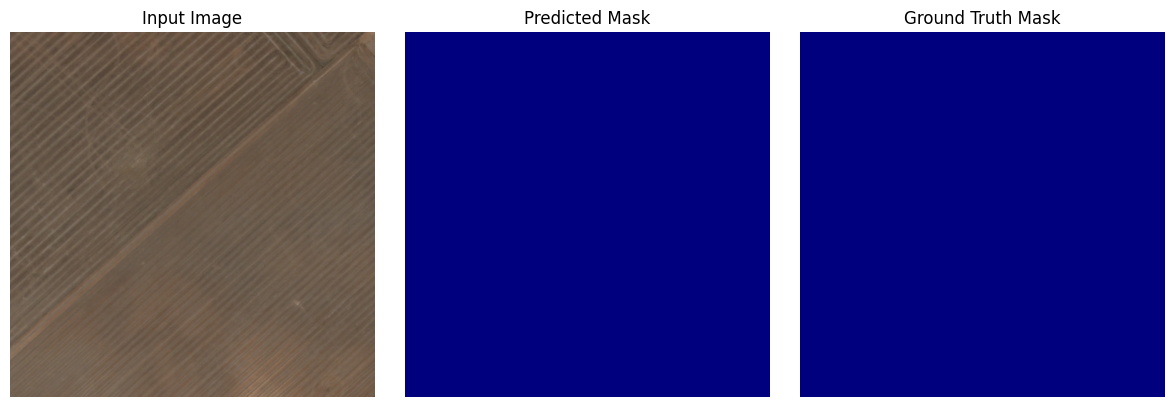

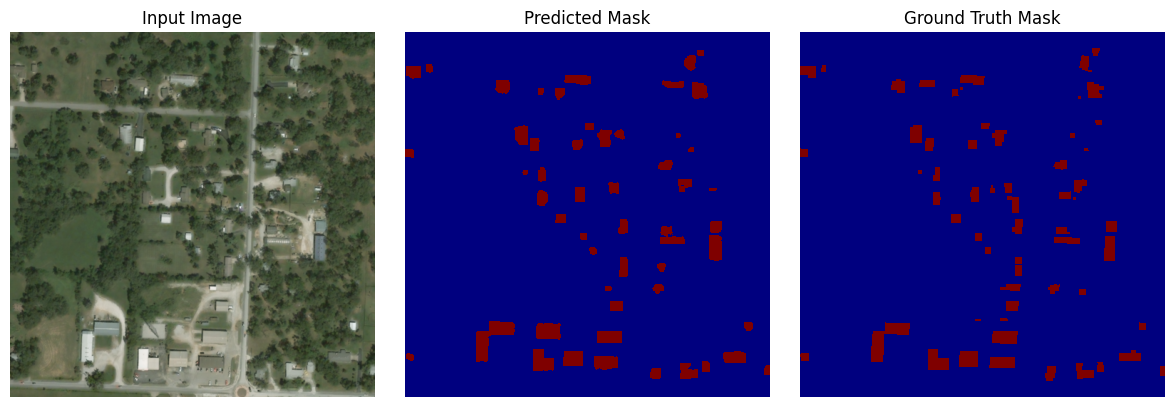

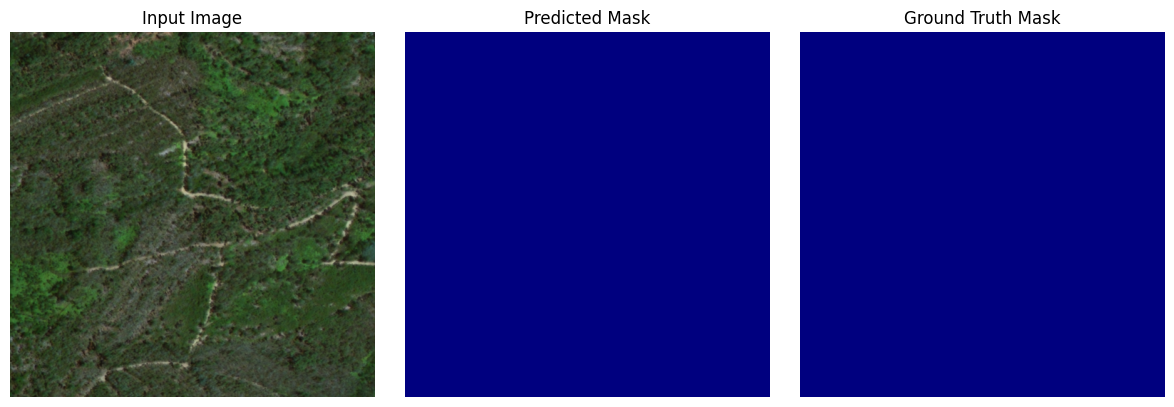

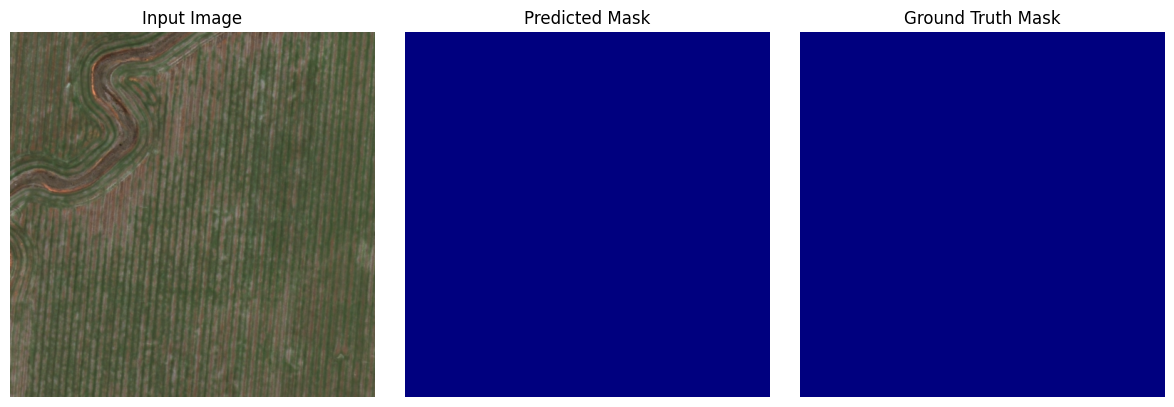

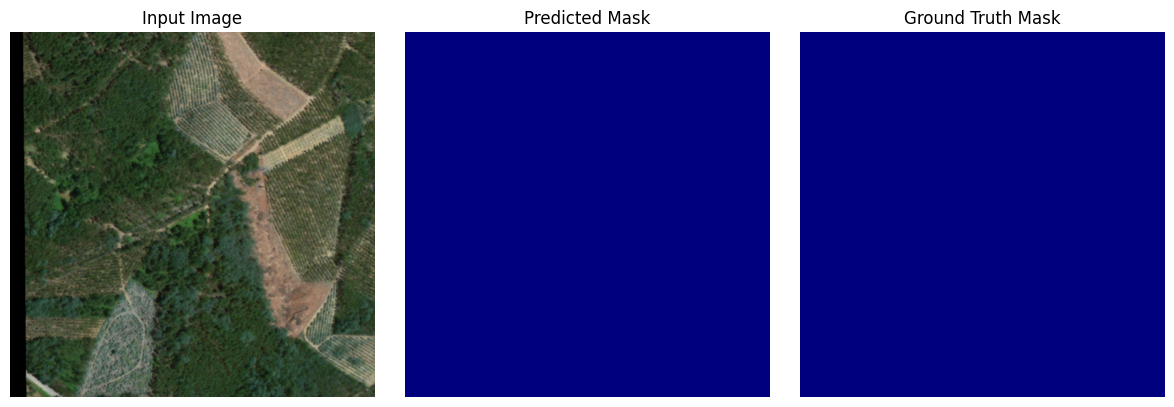

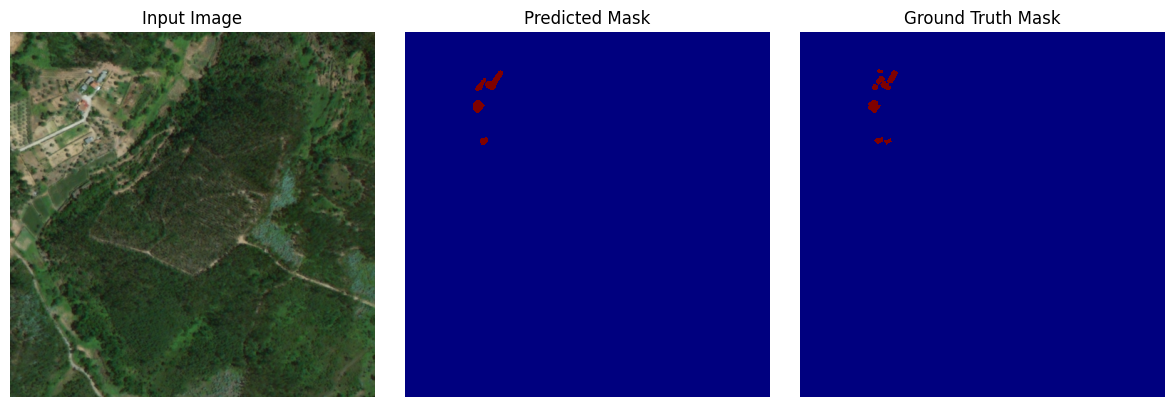

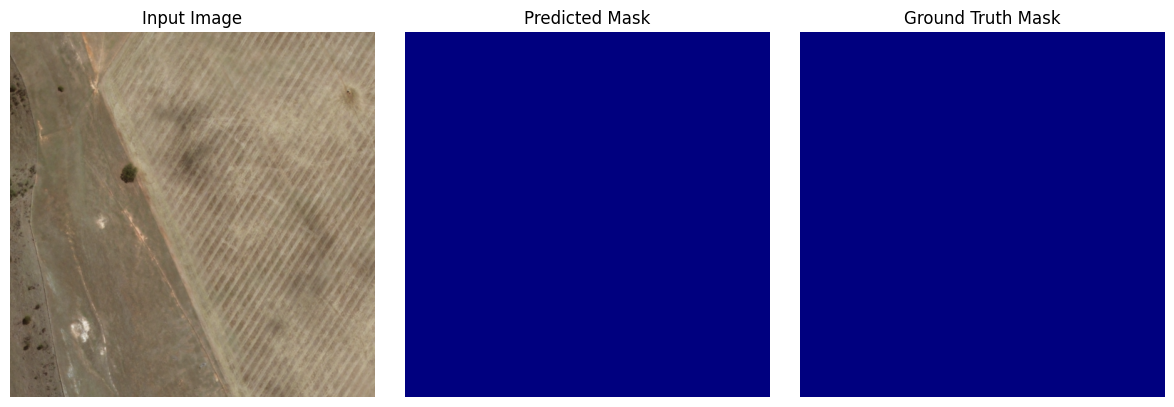

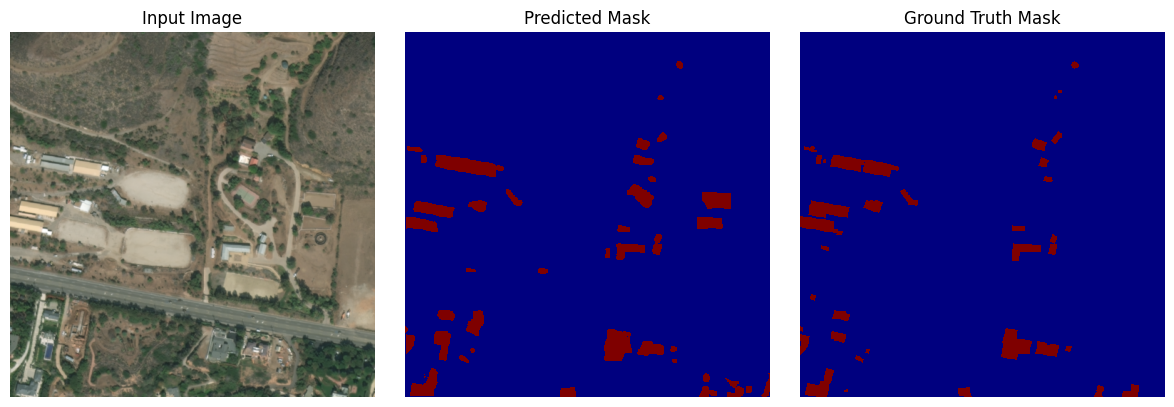

In [29]:
display_semantic_predictions_batch(images=images, mask_predictions=mask_predictions, mask_labels=mask_labels,normalized=True )